# Thing to look into

<h3>Executive Summary</h3>
The analysis aims to evaluate aspects of bankruptcy, fraud, and collections while providing proactive service offers for customers. Through this report, we delve into three main areas: Customer Acquisition, Spending Behaviour, and Repayment Behaviour.




In [195]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Avoid warnings
import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [196]:
# Import CSV
Cus_df =pd.read_csv("kaggle/Customer Acqusition.csv")
Repay_df=pd.read_csv("kaggle/Repayment.csv")
Spend_df=pd.read_csv("kaggle/spend.csv")

# Make A Copy
Cus_cpy_df=Cus_df.copy()
Repay_cpy_df=Repay_df.copy()
Spend_cpy_df=Spend_df.copy()

#Spend_df.sample(5)

In [197]:
# Checking for missing data

"""
No Missing Data 
Cus_df.isnull().sum()
Spend_df.isnull().sum()
Repay_df.isnull().sum() - missing data
"""

#Cus_df.describe(include='all')
#Spend_df.describe(include='all')
#Repay_df.describe(include='all')


'\nNo Missing Data \nCus_df.isnull().sum()\nSpend_df.isnull().sum()\nRepay_df.isnull().sum() - missing data\n'

In [198]:
#Missing value treatment, Drop uncessary columns and Correct spelling
Repay_df.shape

#Drop Unnamed:4 column - it is uncessary columns
#Fill NAN with its index+1 in the columns SL No: - we might need it later on
Repay_cpy_df = Repay_cpy_df.drop(labels='Unnamed: 4', axis=1)
Repay_cpy_df['SL No:'] = Repay_cpy_df.index+1
Repay_cpy_df = Repay_cpy_df.dropna()
Repay_cpy_df = Repay_cpy_df.rename(columns={"Month":"Repay_Date","Amount":"Repay_Amt","SL No:":"SL_No:"})
Repay_cpy_df['Repay_Date']=pd.to_datetime(Repay_cpy_df['Repay_Date'], format='%d-%b-%y', errors='ignore')


#Corret Spelling
Cus_cpy_df = Cus_cpy_df.rename(columns={"Product":"Tier"})
Cus_cpy_df['Tier'] = Cus_cpy_df['Tier'].replace('Platimum', 'Platinum')


Spend_cpy_df['Type']= Spend_cpy_df['Type'].replace('PETRO','PETROL')
Spend_cpy_df = Spend_cpy_df.rename(columns={"Month":"Purchase_Date","Amount":"Spend_Amt","Sl No:":"SL_No:"})
Spend_cpy_df['Purchase_Date']=pd.to_datetime(Spend_cpy_df['Purchase_Date'], format='%d-%b-%y', errors='ignore')


#Clean_Repay_df.shape
#Cus_df['Customer'].shape
#Cus_cy_df

In [199]:
#Additional Categories agegroup

def agegroup (age):
#     if age < 13:
#         return 'kid'
    if age < 20:
        return 'Teenager'
    elif age >=20 and age <60:
        return 'Adult'
    elif age >= 60:
        return 'OlderAdult'
Cus_cpy_df['AgeGroup'] = Cus_cpy_df['Age'].apply(agegroup)


In [200]:
# Check Output

# Cus_cpy_df.loc[Cus_cpy_df['Age'] < 20]
# Cus_cpy_df

# Visualisation

In [201]:
#Load Visualisation Plugin

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import plotly.express as px
from matplotlib import ticker

sns.set()

<h2>Cilent Composition</h2>

In [202]:
Cus_N_Spend_df = pd.merge(Cus_cpy_df,Spend_cpy_df,on='Customer',how='inner')
# Cus_N_Spend_df['Limit'].unique()

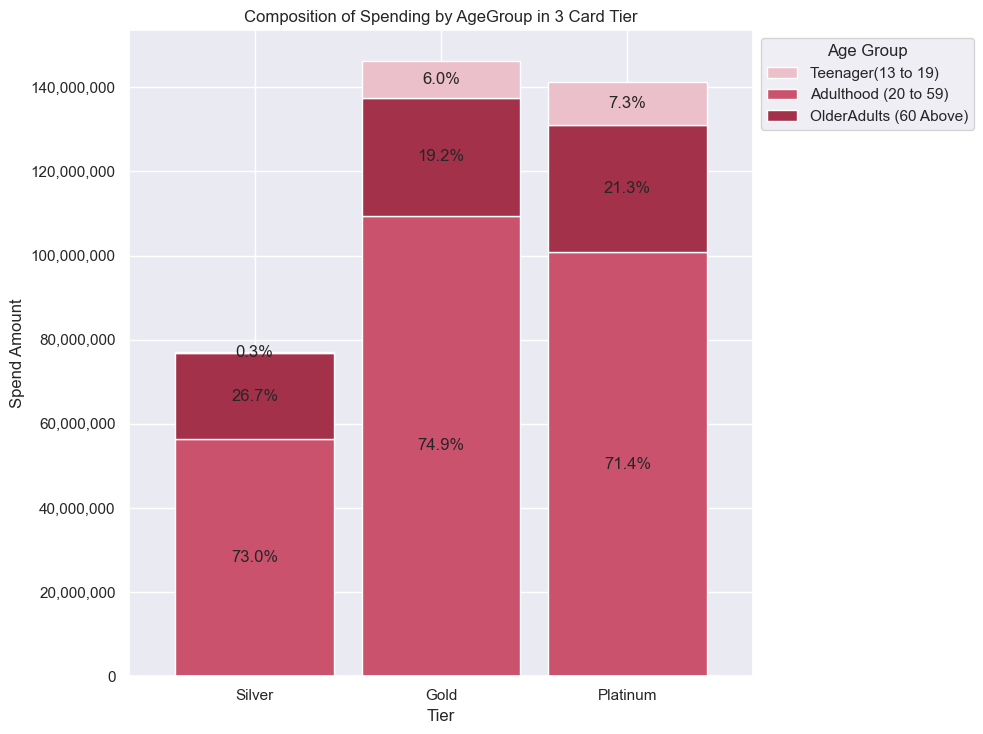

In [203]:


# Sorting the data by 'Tier' and 'AgeGroup'
amount_sum_by_agegroup_type = Cus_N_Spend_df.groupby(['AgeGroup', 'Tier'])['Spend_Amt'].sum().reset_index()
amount_sum_by_agegroup_type.sort_values(['Tier', 'AgeGroup'], inplace=True)


#color_palette
stack_color_palette=['#CB526C','#A4314A','#ECC0CA']


# Create the pivot data again
pivot_data = amount_sum_by_agegroup_type.pivot(index='Tier', columns='AgeGroup', values='Spend_Amt')

# Create the plot
ax = pivot_data.loc[['Silver', 'Gold', 'Platinum']].plot(kind='bar',stacked=True,figsize=(10,7.5),color=stack_color_palette, width=0.85)

# Set labels and title
plt.xlabel('Tier')
plt.ylabel('Spend Amount')
plt.title('Composition of Spending by AgeGroup in 3 Card Tier')

# Set the order of x-axis ticks
preferred_order_tier = ['Silver', 'Gold', 'Platinum']
ax.set_xticklabels(preferred_order_tier)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=0)

# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)


# Set the order and title for legends
handles, labels = ax.get_legend_handles_labels()
preferred_order_agegroup = ['Teenager', 'Adult', 'OlderAdult']
labels, handles = zip(*sorted(zip(labels, handles), key=lambda x: preferred_order_agegroup.index(x[0])))

#rename legends
labels = ['Teenager(13 to 19)', 'Adulthood (20 to 59)', 'OlderAdults (60 Above)']
ax.legend(handles, labels, title='Age Group', loc='upper left', bbox_to_anchor=(1, 1))


# Annotate the bars
for idx, label in enumerate(preferred_order_tier):
    total = pivot_data.loc[label].sum()  # total amount for this tier
    y_offset = 0  # To keep track of where to put text in the y-axis
    for col in pivot_data.columns:
        value = pivot_data.loc[label, col]
        if value == 0:  # Skip zero values
            continue
        percentage = (value / total) * 100  # Calculate the percentage
        y_pos = y_offset + (value / 2)  # Position to place text in y-axis
        ax.text(idx, y_pos, f"{percentage:.1f}%", ha='center', va='center')
        y_offset += value # Increase the y_offset for next iteration

    
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


<h2> Geographic distribution </h2>

In [204]:
#Tempt Commet out TreeMap

#data
amount_sum_by_city_type=Cus_N_Spend_df.groupby(['City','Tier','Type'])['Spend_Amt'].sum().reset_index()
tier_counts_by_city = Cus_N_Spend_df.groupby(['City','Tier','Type']).size().reset_index(name='Tier_Count')

result_df = pd.merge(amount_sum_by_city_type, tier_counts_by_city, on=['City', 'Type','Tier'])

fig = px.treemap(result_df,path=['City','Tier','Type'],values='Spend_Amt',custom_data=['Tier_Count'])


# Update hover template for formatting
fig.update_traces(
#    hovertemplate='<b>%{label}</b><br>Value: $%{Amount[0]:,.2f}'
    hovertemplate='<b>%{label}</b><br>Amount: $%{value:,.2f}<br>Transaction: %{customdata[0]}'
)

# Update layout for better visualization
fig.update_layout(
    margin=dict(l=20, r=20, t=30, b=20),
    title='Geographic distribution',
    title_x=0.5,
    title_y=0.95
)

# Show the plot
fig.show()


<h2>Card Tier Transaction, Spend Amount, Mean, Median</h2>

In [205]:
sorted_tiers = ['Silver', 'Gold', 'Platinum']

grouped_data = Cus_N_Spend_df.groupby('Tier')['Type'].value_counts()
grouped_sum = Cus_N_Spend_df.groupby('Tier')['Type'].count()
grouped_Amount_sum = Cus_N_Spend_df.groupby('Tier')['Spend_Amt'].sum()
grouped_Amount_mean = Cus_N_Spend_df.groupby('Tier')['Spend_Amt'].mean()
grouped_Amount_median = Cus_N_Spend_df.groupby('Tier')['Spend_Amt'].median()
grouped_Amount_max= Cus_N_Spend_df.groupby('Tier')['Spend_Amt'].max()
grouped_Amount_min= Cus_N_Spend_df.groupby('Tier')['Spend_Amt'].min()


table = grouped_data.unstack().fillna(0)
table['Transaction'] = grouped_sum
table['Spend_Amt'] =  grouped_Amount_sum.apply(lambda x: "{:,.0f}".format(x))
table['Mean_Amt']=  grouped_Amount_mean.apply(lambda x: "{:,.0f}".format(x))
table['Median_Amt']=  grouped_Amount_median.apply(lambda x: "{:,.0f}".format(x))
table['MaxSpend_Amt']=  grouped_Amount_max.apply(lambda x: "{:,.0f}".format(x))
table['MinSpend_Amt']=  grouped_Amount_min.apply(lambda x: "{:,.0f}".format(x))


sorted_table = table.reindex(sorted_tiers)
sorted_table.index.name = None

sorted_table.rename(columns={'Type': 'Tier'}, inplace=True)
sorted_table.rename_axis(columns=None, inplace=True)
# sorted_table.iloc[:,-6:]
# sorted_table.describe()
sorted_table

,AIR TICKET,AUTO,BIKE,BUS TICKET,CAMERA,CAR,CLOTHES,FOOD,JEWELLERY,MOVIE TICKET,...,RENTAL,SANDALS,SHOPPING,TRAIN TICKET,Transaction,Spend_Amt,Mean_Amt,Median_Amt,MaxSpend_Amt,MinSpend_Amt
Silver,31,6,7,18,37,5,21,30,19,19,...,17,8,22,35,320,"77,128,966","241,028","233,436","498,735","8,987"
Gold,63,14,17,45,75,12,33,62,31,25,...,34,11,45,60,610,"146,200,355","239,673","239,598","498,389",720
Platinum,53,20,25,36,48,13,41,68,45,32,...,25,9,46,37,570,"141,314,753","247,921","241,250","499,793",973


<h2>AgeGroup Transaction, Spend Amount, Mean, Median</h2>

In [206]:
sorted_tiers2 = ['Teenager', 'Adults', 'OlderAdults']

grouped_Age_data = Cus_N_Spend_df.groupby('AgeGroup')['Type'].value_counts()

# Unstack the groupby object
table2 = grouped_Age_data.unstack().fillna(0)

# Optionally sum along rows or columns as per your requirement
table2['Total'] = table2.sum(axis=1)  # This sums up along rows

table2.index.name = None
table2.rename_axis(columns=None, inplace=True)

table2

,AIR TICKET,AUTO,BIKE,BUS TICKET,CAMERA,CAR,CLOTHES,FOOD,JEWELLERY,MOVIE TICKET,PETROL,RENTAL,SANDALS,SHOPPING,TRAIN TICKET,Total
Adult,107.0,30.0,33.0,62.0,108.0,25.0,70.0,108.0,69.0,62.0,147.0,52.0,17.0,84.0,104.0,1078.0
OlderAdult,31.0,7.0,13.0,30.0,43.0,5.0,23.0,44.0,16.0,14.0,41.0,21.0,11.0,16.0,23.0,338.0
Teenager,9.0,3.0,3.0,7.0,9.0,0.0,2.0,8.0,10.0,0.0,12.0,3.0,0.0,13.0,5.0,84.0


<h2>Creating Credit Score</h2>

In [207]:
Cus_cpy_df.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Limit', 'Company', 'Segment',
       'AgeGroup'],
      dtype='object')

In [208]:
Spend_cpy_df.columns

Index(['SL_No:', 'Customer', 'Purchase_Date', 'Type', 'Spend_Amt'], dtype='object')

In [209]:
Repay_cpy_df.columns

Index(['SL_No:', 'Customer', 'Repay_Date', 'Repay_Amt'], dtype='object')

In [210]:
df_merged =pd.merge(Cus_N_Spend_df,Repay_cpy_df,on=['Customer','SL_No:'],how='inner')
# df_merged

In [211]:
# Ensure your 'purchase date' and 'repay date' columns are in datetime format
df_merged['Purchase_Date'] = pd.to_datetime(df_merged['Purchase_Date'])
df_merged['Repay_Date'] = pd.to_datetime(df_merged['Repay_Date'])

# Create month-year columns for purchase and repay
df_merged['Purchase_month_year'] = df_merged['Purchase_Date'].dt.to_period('M')
df_merged['Repay_month_year'] = df_merged['Repay_Date'].dt.to_period('M')


def months_to_years_months(months):
    years = months // 12
    remaining_months = months % 12
    return f"{years} years and {remaining_months} months"

df_merged.columns

Index(['No', 'Customer', 'Age', 'City', 'Tier', 'Limit', 'Company', 'Segment',
       'AgeGroup', 'SL_No:', 'Purchase_Date', 'Type', 'Spend_Amt',
       'Repay_Date', 'Repay_Amt', 'Purchase_month_year', 'Repay_month_year'],
      dtype='object')

In [212]:
#Did they pay on time Monthly? Did they spent over their limit?

# def years_to_years_months(years_decimal):
#     whole_years = int(years_decimal)
#     remaining_months = int((years_decimal - whole_years) * 12)
#     return f"{whole_years} yrs and {remaining_months} mths"

def risk_model(row):
    # Initialize risk score
    risk_score = 0
    
    # Payment history
    if row['Repaid']:
        #true
        risk_score += 2
    else:
        #false
        risk_score -= 2
    
    # Credit Spent within their Limit
    limit_utilization = row['Spend_Amt sum'] / row['Limit max']
    if limit_utilization < 1:
        risk_score -= 1
    elif limit_utilization > 1:
        risk_score += 1
    
    return risk_score

#     # Calculate risk group based on score
#     if risk_score >= 15:
#         return 'Low Risk'
#     elif risk_score >= 5:
#         return 'Medium Risk'
#     else:
#         return 'High Risk'

# Define aggregation functions
agg_funcs = {
    'Spend_Amt': ['sum'],
    'Repay_Amt': ['sum'],
    'Purchase_Date': ['min'],  # Latest purchase date
    'Repay_Date': ['max'],  # Latest repayment date
    'Limit': 'max',
    'Age':['max']
}


# Group by customer, tier, and month-year
df_grouped_monthly = df_merged.groupby(['Customer', 'Tier','Purchase_month_year']).agg(agg_funcs).reset_index()

# Flatten the multi-level column index if needed
df_grouped_monthly.columns = [' '.join(col).strip() for col in df_grouped_monthly.columns]

# Calculate where Repay Amt > Spend Amt on a monthly basis
df_grouped_monthly['Repaid'] = df_grouped_monthly['Repay_Amt sum'] > df_grouped_monthly['Spend_Amt sum']

#Num of Years
# df_grouped_monthly['Num of Years'] = df_grouped_monthly['purchase date min'] - df_grouped_monthly['repay date max']
# df_grouped_monthly['Num of Years'] = abs(df_grouped_monthly['Num of Years'].dt.days / 365.25)
# df_grouped_monthly['Num of Years'] = df_grouped_monthly['Num of Years'].apply(years_to_years_months)

# Assuming df_grouped_monthly has all required columns
df_grouped_monthly['Risk_Group'] = df_grouped_monthly.apply(risk_model, axis=1)


df_grouped_monthly.loc[df_grouped_monthly['Customer']=="A12"]
# df_grouped_monthly


,Customer,Tier,Purchase_month_year,Spend_Amt sum,Repay_Amt sum,Purchase_Date min,Repay_Date max,Limit max,Age max,Repaid,Risk_Group
33,A12,Gold,2004-01,1469719.85,1543819.86,2004-01-03,2006-10-03,500000.0,51,True,3
34,A12,Gold,2004-02,214891.01,219352.84,2004-02-05,2004-01-25,500000.0,51,True,1
35,A12,Gold,2004-09,479627.87,289407.01,2004-09-13,2004-09-13,500000.0,51,False,-3
36,A12,Gold,2005-01,593592.61,111850.38,2005-01-17,2006-03-24,500000.0,51,False,-1
37,A12,Gold,2005-02,840740.18,1156523.11,2005-02-03,2006-06-03,500000.0,51,True,3
38,A12,Gold,2005-04,506156.42,375691.76,2005-04-04,2005-04-04,500000.0,51,False,-1
39,A12,Gold,2005-05,1222506.99,869047.06,2005-05-07,2006-03-31,500000.0,51,False,-1
40,A12,Gold,2005-06,682498.03,962231.34,2005-06-01,2006-07-11,500000.0,51,True,3
41,A12,Gold,2005-11,383087.29,429751.89,2005-11-22,2004-04-25,500000.0,51,True,1
42,A12,Gold,2006-03,841405.99,968448.57,2006-03-03,2006-05-06,500000.0,51,True,3


In [213]:
#Function
def years_to_years_months(years_decimal):
    if years_decimal > 0:
        whole_years = int(years_decimal)
        remaining_months = int((years_decimal - whole_years) * 12)
        return f"{whole_years} yrs and {remaining_months} mths"
    else:
        return 'New User'


# Define aggregation functions
agg_funcs = {
    'Risk_Group': ['sum','median','mean'],
    'Customer':['count'],
    'Spend_Amt sum': ['sum','mean'],
    'Repay_Amt sum': ['sum'],
    'Purchase_Date min': ['min'],  # Latest purchase date
    'Repay_Date max': ['max'],
    'Age max':['max'],
    'Limit max':['max'],
    # Latest repayment date
    
#   'Limit max' :['max']
}

df_grouped2 =df_grouped_monthly.groupby(['Customer']).agg(agg_funcs).reset_index()
df_grouped2.columns = [' '.join(col).strip() for col in df_grouped2.columns]

df_grouped2.rename(columns={
    'Risk_Group mean': 'RiskGroup_Mean',
    'Risk_Group median': 'RiskGroup_Median',
    'Risk_Group sum': 'RiskGroup_Sum',
    'Customer count': 'Num_Of_Transaction',
    'Spend_Amt sum sum': 'Total_SpendAmt',
    'Repay_Amt sum sum': 'Total_RepayAmt',
    'Limit max max': 'MaxLimit',
    'Age max max':'Age'
}, inplace=True)


#Num of Years
df_grouped2['Num_of_Years'] = df_grouped2['Purchase_Date min min'] - df_grouped2['Repay_Date max max']
df_grouped2['Num_of_Years'] = abs(df_grouped2['Num_of_Years'].dt.days / 365.25)
# df_grouped2['Num_of_Years'] = df_grouped2['Num_of_Years'].apply(years_to_years_months)

df_grouped2 = df_grouped2.drop(['Purchase_Date min min','Repay_Date max max'], axis=1)

In [214]:
#Average spending by age group, credit score, and geographic location
df_grouped2

,Customer,RiskGroup_Sum,RiskGroup_Median,RiskGroup_Mean,Num_Of_Transaction,Total_SpendAmt,Spend_Amt sum mean,Total_RepayAmt,Age,MaxLimit,Num_of_Years
0,A1,-5,-1.0,-0.555556,9,5142702.76,571411.417778,4753691.67,76,500000.0,2.882957
1,A10,-9,-1.0,-0.818182,11,3847424.65,349765.877273,3695647.52,54,500000.0,2.485969
2,A100,-1,-1.0,-1.000000,1,224786.88,224786.880000,69551.19,36,100000.0,0.000000
3,A11,-8,0.0,-0.666667,12,4517227.69,376435.640833,5310934.03,35,500000.0,2.494182
4,A12,8,1.0,0.571429,14,8183050.64,584503.617143,8334760.16,51,500000.0,2.748802
...,...,...,...,...,...,...,...,...,...,...,...
95,A95,1,1.0,1.000000,1,240401.50,240401.500000,369405.96,62,500000.0,0.000000
96,A96,1,1.0,1.000000,1,54729.66,54729.660000,310992.30,54,100000.0,0.000000
97,A97,-1,-1.0,-1.000000,1,139018.26,139018.260000,121874.90,58,10000.0,0.000000
98,A98,3,3.0,3.000000,1,284521.06,284521.060000,337815.57,51,10001.0,0.000000


<h2> How many spent within the credit limit and have pay on time monthly? </h2>

In [215]:
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [216]:
df_grouped2.columns

Index(['Customer', 'RiskGroup_Sum', 'RiskGroup_Median', 'RiskGroup_Mean',
       'Num_Of_Transaction', 'Total_SpendAmt', 'Spend_Amt sum mean',
       'Total_RepayAmt', 'Age', 'MaxLimit', 'Num_of_Years'],
      dtype='object')

In [217]:
# df_grouped2['Total_SpendAmt']

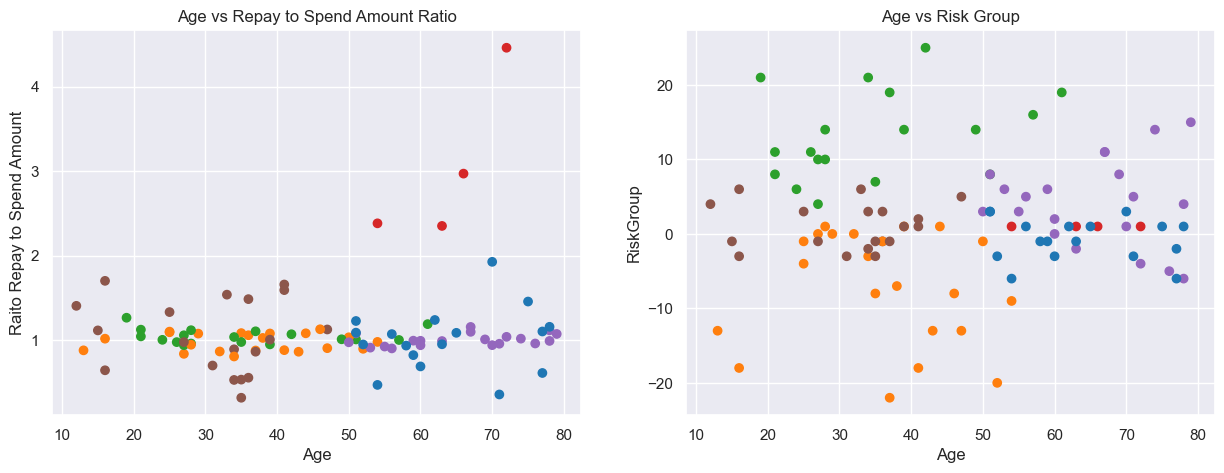

In [218]:
# Step 1: Feature Engineering
# Creating a new feature: Spend to Credit Limit Ratio
df_grouped2['RepayAmt_to_Spend'] = np.sqrt(df_grouped2['Total_RepayAmt'] / df_grouped2['Total_SpendAmt'])

# Step 2: Data Standardization
scaler = StandardScaler()
features_to_scale = ['Age','Total_SpendAmt','RiskGroup_Sum','RepayAmt_to_Spend']
df_scaled = scaler.fit_transform(df_grouped2[features_to_scale])

# Step 3: Applying KMeans Clustering
kmeans = KMeans(n_clusters=6)  # For this example, I'm using 3 clusters
df_grouped2['Cluster'] = kmeans.fit_predict(df_scaled)

# If you need the 'Cluster' in the original DataFrame (if it is Cus_N_Spend_df)
# print("Cluster Centers: ", kmeans.cluster_centers_)
# print("Clusters: ", df_grouped2['Cluster'].value_counts())

# def generate_random_colors(num_colors):
#     color_list = []
#     for i in range(num_colors):
#         color_list.append("#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]))
#     return color_list

# Define distinct colors
# distinct_colors =  generate_random_colors(n_clusters)

distinct_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
df_grouped2['Color'] = df_grouped2['Cluster'].apply(lambda x: distinct_colors[x])


# Create a grid of subplots: 1 row, 3 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# Convert cluster numbers to distinct colors
df_grouped2['Color'] = df_grouped2['Cluster'].apply(lambda x: distinct_colors[x])

# Visualization using the right DataFrame and columns
sc1 = axes[0].scatter(y=df_grouped2['RepayAmt_to_Spend'], x=df_grouped2['Age'],c=df_grouped2['Color'])
axes[0].set_title('Age vs Repay to Spend Amount Ratio')
axes[0].set_ylabel('Raito Repay to Spend Amount')

sc2 = axes[1].scatter(y=df_grouped2['RiskGroup_Sum'], x=df_grouped2['Age'], c=df_grouped2['Color'])
axes[1].set_title('Age vs Risk Group')
axes[1].set_ylabel('RiskGroup')


# Set x-label for all subplots
for ax in axes:
    ax.set_xlabel('Age')

# Create the colorbar based on one of the scatter plots (either sc1 or sc2), and associate with the axes
# cbar = plt.colorbar(sc1, ax=axes.ravel().tolist(), ticks=list(range(9)), label='Cluster')

plt.show()

In [219]:
df_grouped2['RepayAmt_to_Spend'].min()

0.3190025157012841

In [220]:
%%capture
# WCSS = Within-cluster Sum of Squares (inertia)
wcss = []

# Let's check for up to 11 clusters, starting from 2
for i in range(2, 12):  # note the change here
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')  # note the change here
plt.xlabel('My Custom Cluster Name')  # note the change here
plt.ylabel('WCSS')
plt.title('K-means Clustering: The Elbow Method')
plt.show()

In [221]:
%%capture
from sklearn.metrics import silhouette_score

silhouette_scores = []

K = range(2, 11)  # The silhouette score is not defined for k=1
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    labels = kmeanModel.fit_predict(df_scaled)
    silhouette_scores.append(silhouette_score(df_scaled, labels))

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis For Optimal k')
plt.show()


In [222]:
%%capture
from sklearn.metrics import davies_bouldin_score

davies_bouldin_scores = []

K = range(2, 11)  # The index is not defined for k=1
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    labels = kmeanModel.fit_predict(df_scaled)
    davies_bouldin_scores.append(davies_bouldin_score(df_scaled, labels))

# Find the lowest score
best_k = K[davies_bouldin_scores.index(min(davies_bouldin_scores))]
best_k

<h2>Categories where most spending occurs</h2>

In [223]:
cat_spend_data.columns 
# Spend_Amt

Index(['Tier_', 'Type_', 'Spend_Amt_sum', 'Spend_Amt_mean', 'Type_count',
       'Type_max'],
      dtype='object')

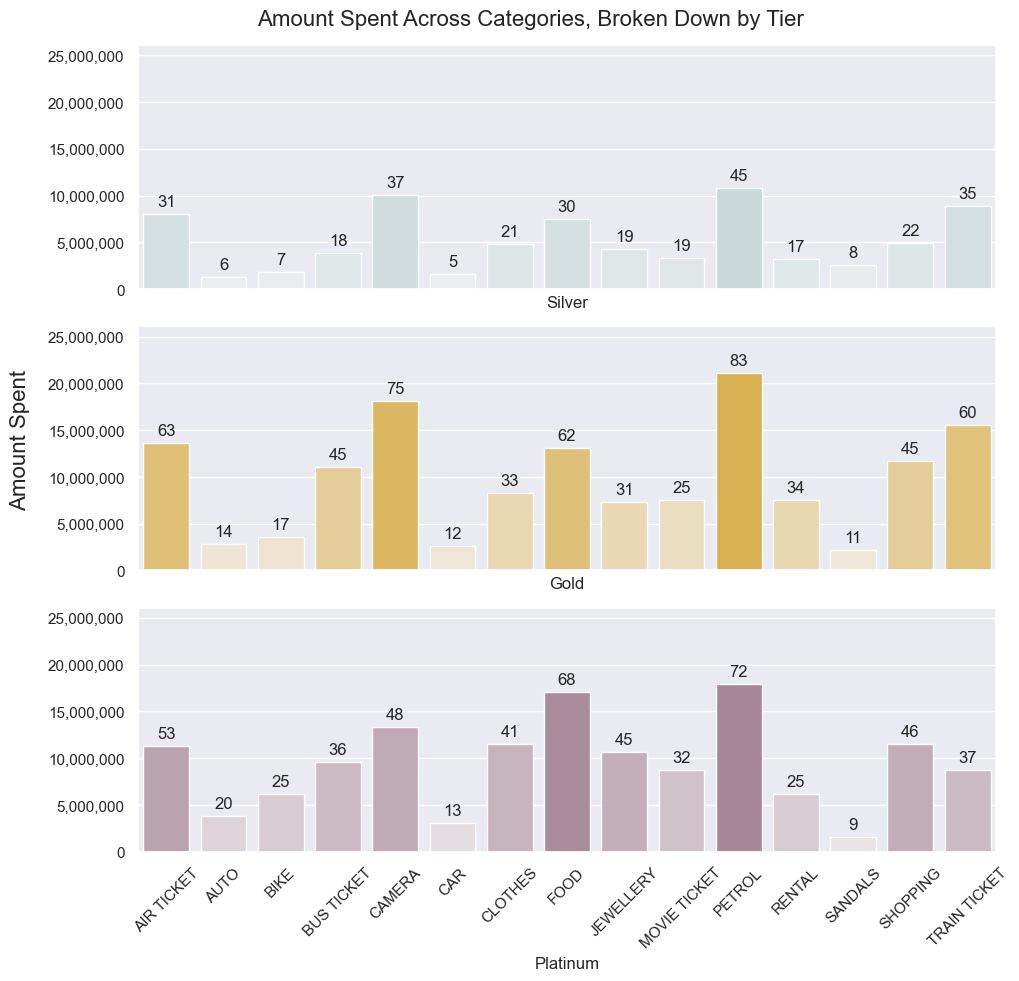

In [224]:
agg_funcs = {
    'Spend_Amt': ['sum','mean'],
    'Type':['count','max']
}

cat_spend_data = Cus_N_Spend_df.groupby(['Tier', 'Type']).agg(agg_funcs).reset_index()
cat_spend_data.columns = ['_'.join(col).strip() for col in cat_spend_data.columns]

filtered_data_ax1 = cat_spend_data[cat_spend_data['Tier_'] == 'Silver']
filtered_data_ax2 = cat_spend_data[cat_spend_data['Tier_'] == 'Gold']
filtered_data_ax3 = cat_spend_data[cat_spend_data['Tier_'] == 'Platinum']

f,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10, 10), sharex=True)

sns.barplot(data=filtered_data_ax1, x='Type_max', y='Spend_Amt_sum',palette=palette_s,ax=ax1)
ax1.set_ylabel("Silver")

sns.barplot(data=filtered_data_ax2, x='Type_max', y='Spend_Amt_sum',palette=palette_g,ax=ax2)
ax2.set_ylabel("Gold")

sns.barplot(data=filtered_data_ax3, x='Type_max', y='Spend_Amt_sum',palette=palette_p,ax=ax3)
ax3.set_ylabel("Platinum")


# Format y-axis ticks with thousands separator
formatter = ticker.StrMethodFormatter('{x:,.0f}')


Spend_Amt_Spacing = 5000000
ax1.set_ylim(0, cat_spend_data['Spend_Amt_sum'].max()+Spend_Amt_Spacing)
ax2.set_ylim(0, cat_spend_data['Spend_Amt_sum'].max()+Spend_Amt_Spacing)
ax3.set_ylim(0, cat_spend_data['Spend_Amt_sum'].max()+Spend_Amt_Spacing)


ax1.yaxis.set_major_formatter(formatter)
ax2.yaxis.set_major_formatter(formatter)
ax3.yaxis.set_major_formatter(formatter)

ax1.set(ylabel=None,xlabel='Silver')
ax2.set(ylabel=None,xlabel='Gold')
ax3.set(ylabel=None,xlabel='Platinum')

plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

def annotate_bars(ax, data):
    for i, p in enumerate(ax.patches):
        count = data.iloc[i]['Type_count']
        ax.annotate(format(count, '.0f'), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')

annotate_bars(ax1, filtered_data_ax1)
annotate_bars(ax2, filtered_data_ax2)
annotate_bars(ax3, filtered_data_ax3)

# Finalize the plot
f.suptitle('Amount Spent Across Categories, Broken Down by Tier', fontsize=16)
f.text(-0.02, 0.55, 'Amount Spent', va='center', rotation='vertical', fontsize=16)

plt.tight_layout(h_pad=1)
plt.show()


In [225]:
%%capture
import matplotlib.pyplot as plt

def plot_pie_chart(ax, data, title, value_column, label_column='Type_max'):
    ax.pie(data[value_column], labels=data[label_column], autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'{title} ({value_column.replace("_", " ").capitalize()})')

# Create subplots: 1 row, 3 columns for 'Silver', 'Gold', and 'Platinum'
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Filter data by each tier
filtered_data_silver = cat_spend_data[cat_spend_data['Tier_'] == 'Silver']
filtered_data_gold = cat_spend_data[cat_spend_data['Tier_'] == 'Gold']
filtered_data_platinum = cat_spend_data[cat_spend_data['Tier_'] == 'Platinum']

# Plot pie charts for the 'Silver' tier
plot_pie_chart(axes[0], filtered_data_silver, 'Silver', 'Spend_Amt_sum')

# Plot pie charts for the 'Gold' tier
plot_pie_chart(axes[1], filtered_data_gold, 'Gold', 'Spend_Amt_sum')

# Plot pie charts for the 'Platinum' tier
plot_pie_chart(axes[2], filtered_data_platinum, 'Platinum', 'Spend_Amt_sum')

plt.show()


In [226]:
# Cus_N_Spend_df.head()

<h2>Trend analysis (seasonality, monthly trends)</h2>

In [227]:
# Create line Chart aginst time to show pruchase trend
Cus_N_Spend_df

,No,Customer,Age,City,Tier,Limit,Company,Segment,AgeGroup,SL_No:,Purchase_Date,Type,Spend_Amt
0,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,1,2004-01-12,JEWELLERY,485470.80
1,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,2,2004-01-03,PETROL,410556.13
2,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,3,2004-01-15,CLOTHES,23740.46
3,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,4,2004-01-25,FOOD,484342.47
4,1,A1,76,BANGALORE,Gold,500000.0,C1,Self Employed,OlderAdult,5,2005-01-17,CAMERA,369694.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,96,A96,54,CHENNAI,Silver,100000.0,C19,Salaried_Pvt,Adult,98,2004-01-25,BIKE,54729.66
1496,97,A97,58,TRIVANDRUM,Platinum,10000.0,C20,Govt,Adult,99,2004-01-12,AUTO,139018.26
1497,98,A98,51,CALCUTTA,Platinum,10001.0,C21,Normal Salary,Adult,100,2004-01-03,SHOPPING,284521.06
1498,99,A99,35,CALCUTTA,Platinum,10002.0,C22,Self Employed,Adult,101,2004-01-15,AIR TICKET,90184.22


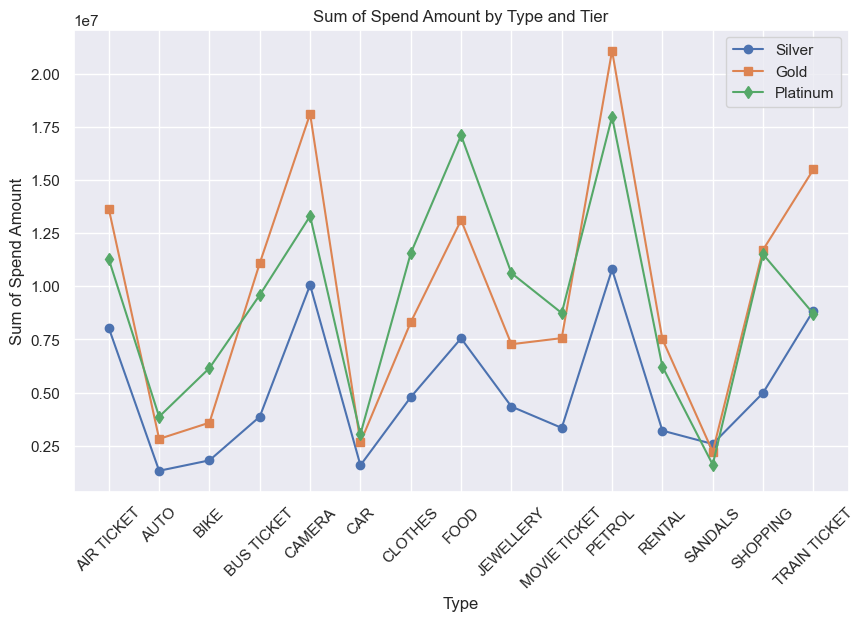

In [228]:
agg_funcs = {
    'Spend_Amt': ['sum','mean'],
    'Type':['count','max'],
    'Customer':['max'],
    'Purchase_Date':['first'],
    'AgeGroup':['first']
}

spend_date_df = Cus_N_Spend_df.groupby(['Tier', 'Type']).agg(agg_funcs).reset_index()
spend_date_df.columns = ['_'.join(col).strip() for col in spend_date_df.columns]

import matplotlib.pyplot as plt

# Separate the data by tier
silver_data = spend_date_df[spend_date_df['Tier_'] == 'Silver']
gold_data = spend_date_df[spend_date_df['Tier_'] == 'Gold']
platinum_data = spend_date_df[spend_date_df['Tier_'] == 'Platinum']

plt.figure(figsize=(10, 6))

# Plot each tier's data
plt.plot(silver_data['Type_max'], silver_data['Spend_Amt_sum'], label='Silver', marker='o')
plt.plot(gold_data['Type_max'], gold_data['Spend_Amt_sum'], label='Gold', marker='s')
plt.plot(platinum_data['Type_max'], platinum_data['Spend_Amt_sum'], label='Platinum', marker='d')

# Customize the chart
plt.title('Sum of Spend Amount by Type and Tier')
plt.xlabel('Type')
plt.ylabel('Sum of Spend Amount')
plt.xticks(rotation=45)
plt.legend()

# Show the chart
plt.show()


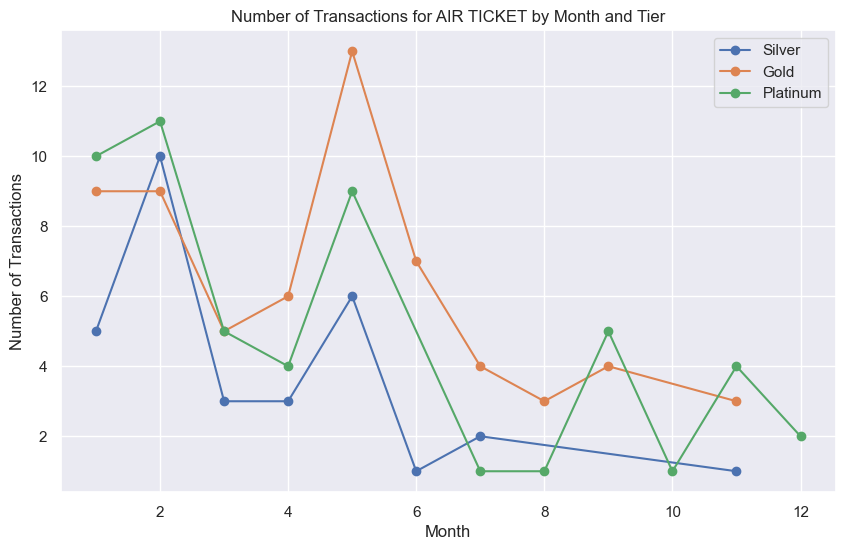

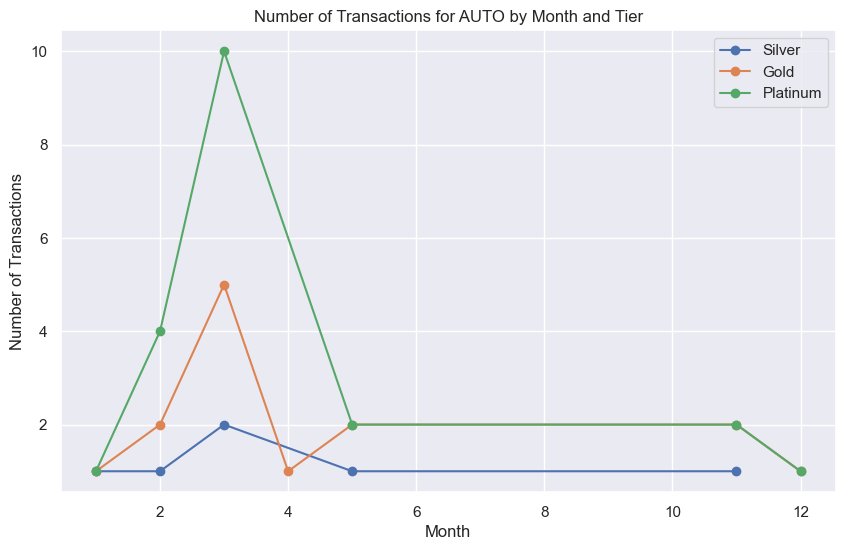

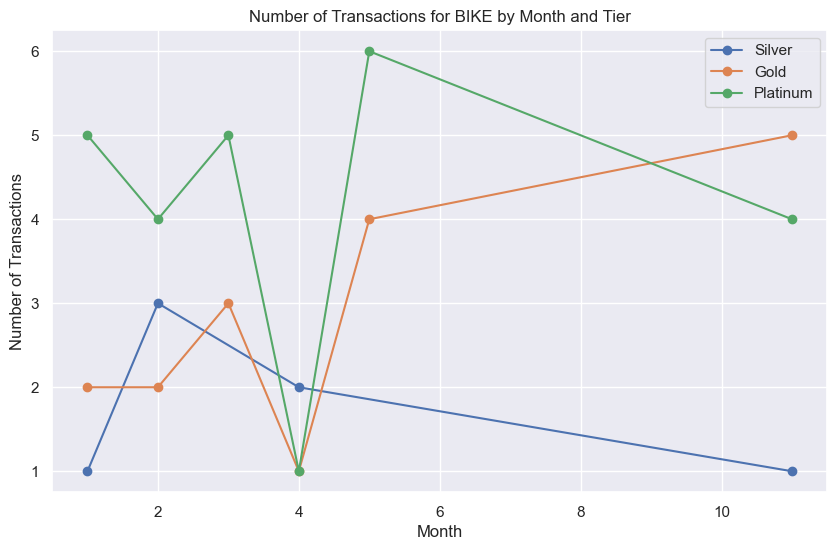

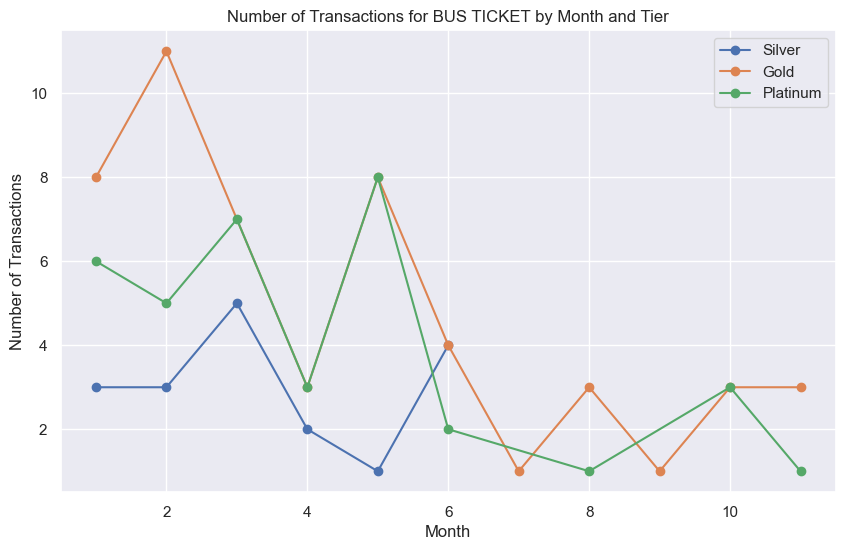

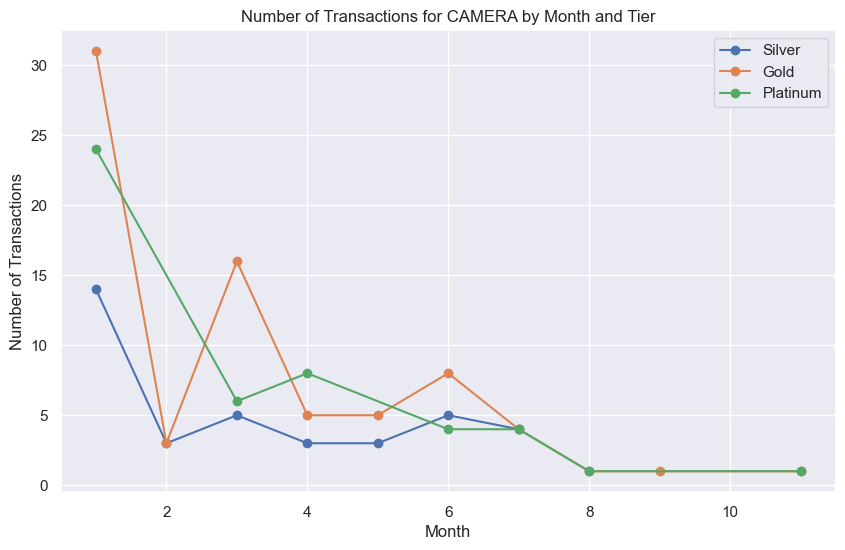

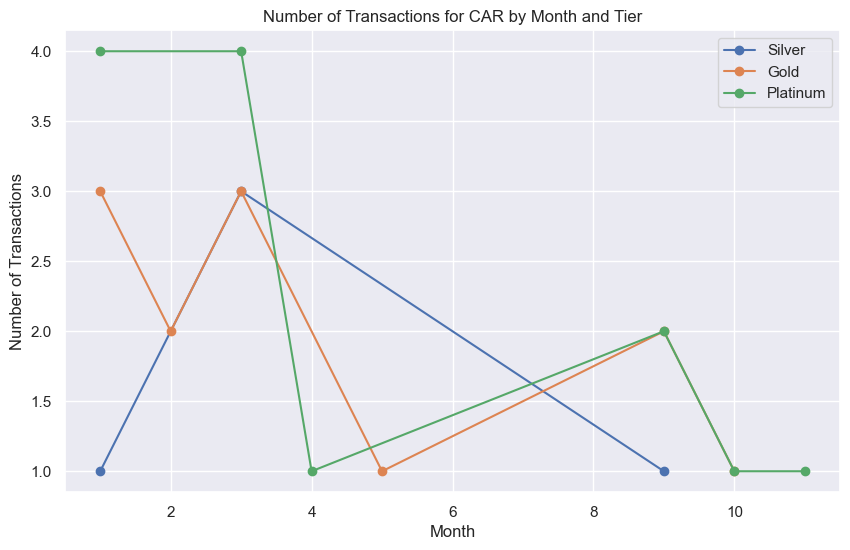

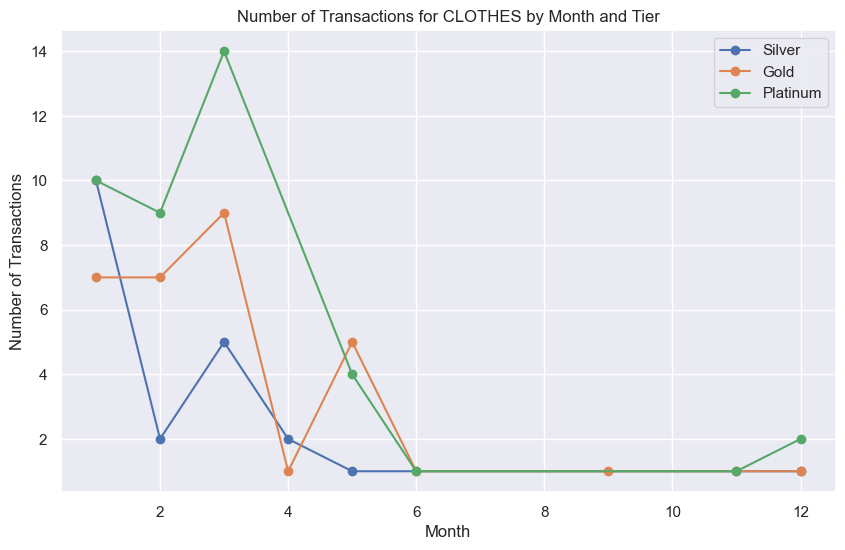

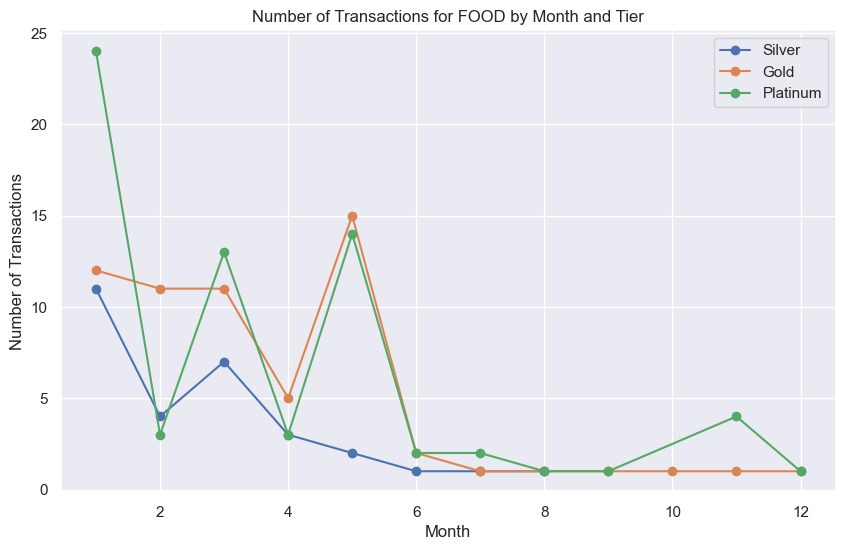

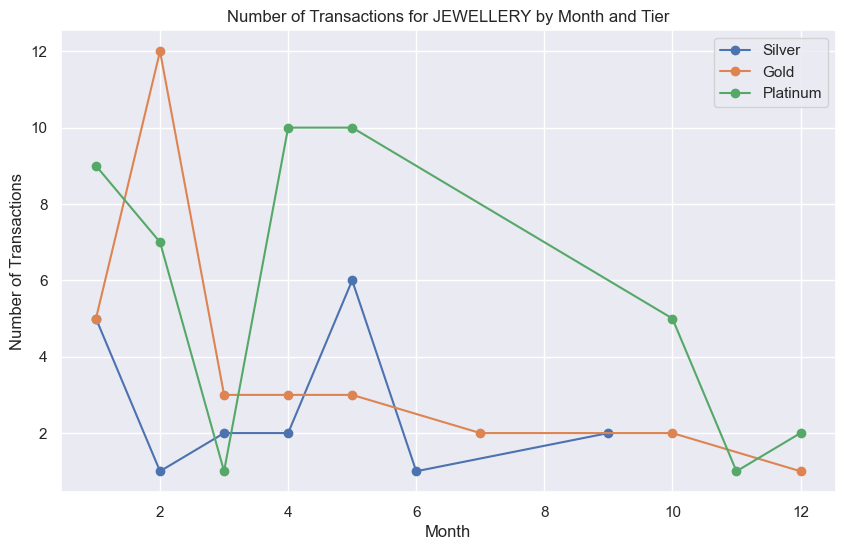

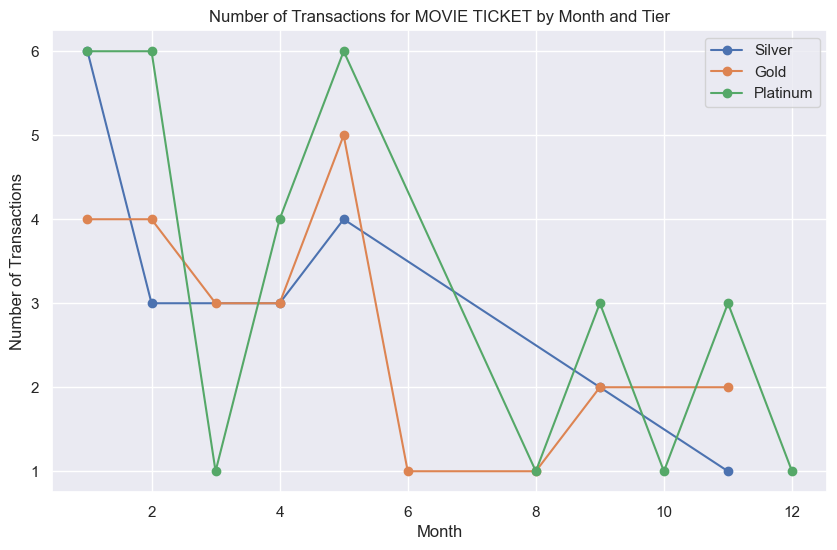

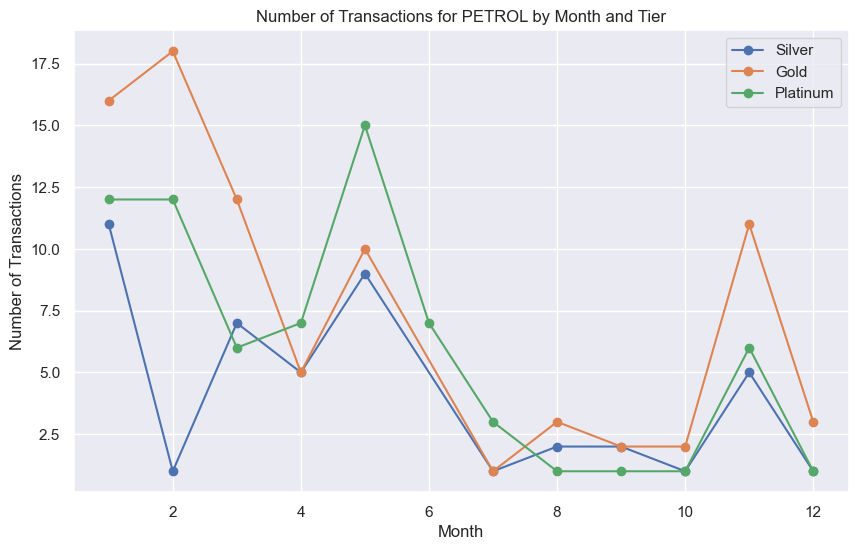

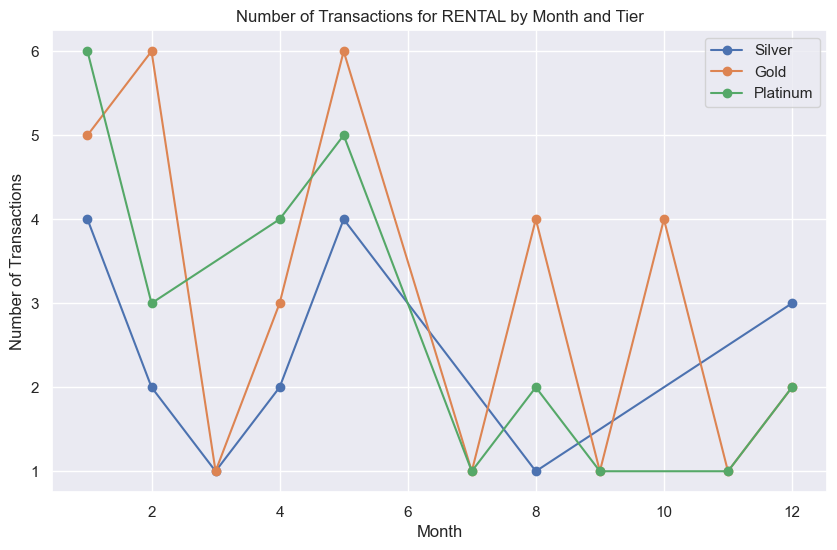

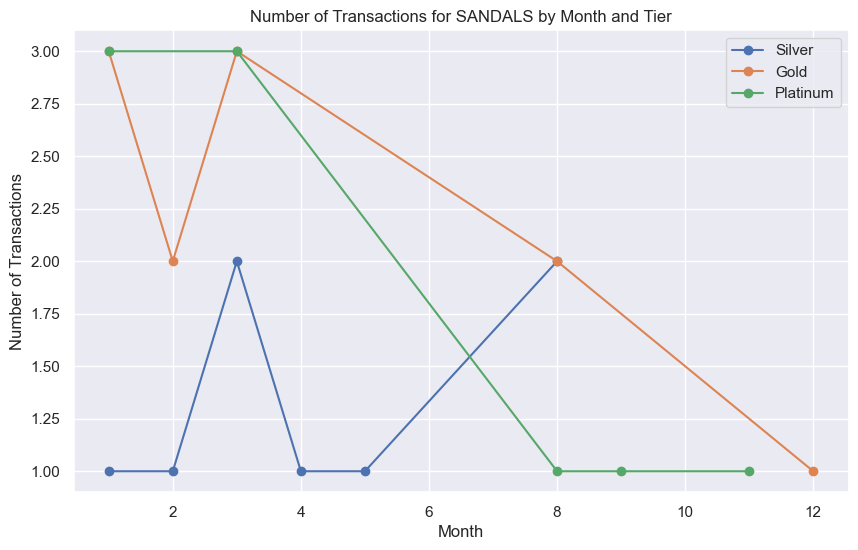

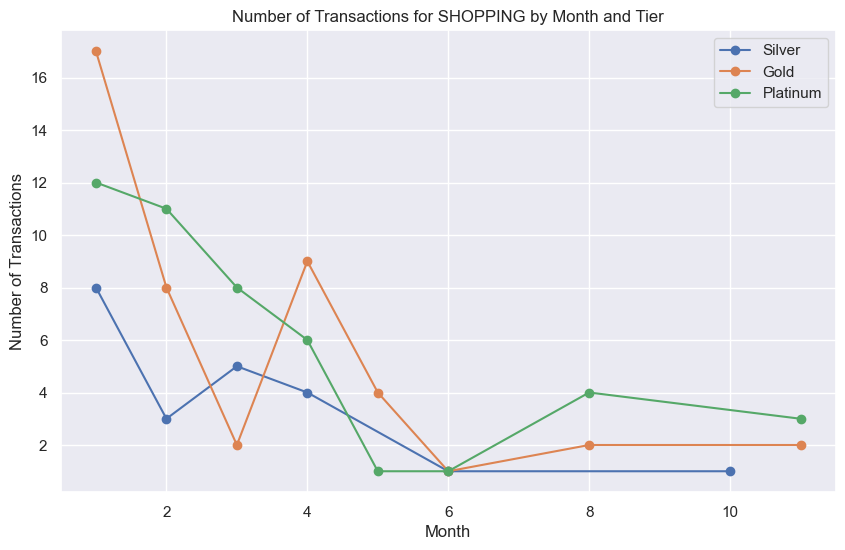

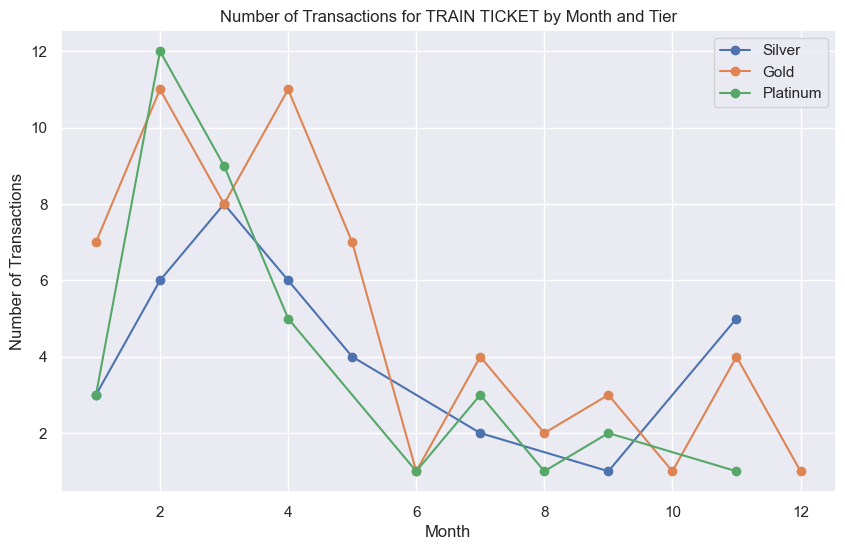

In [229]:
# Convert 'Purchase_Date' to datetime if it's not already
Cus_N_Spend_df['Purchase_Date'] = pd.to_datetime(Cus_N_Spend_df['Purchase_Date'])

# Extract the month from the date
Cus_N_Spend_df['Purchase_Month'] = Cus_N_Spend_df['Purchase_Date'].dt.month

agg_funcs = {
    'Spend_Amt': ['sum'],
    'Type':['count']
}

monthly_type_data = Cus_N_Spend_df.groupby(['Purchase_Month', 'Tier', 'Type']).agg(agg_funcs).reset_index()
monthly_type_data.columns = ['_'.join(col).strip() for col in monthly_type_data.columns]


# Create a list of all unique Types
unique_types = monthly_type_data['Type_'].unique()

# Loop through all unique Types and create a line plot for each
for unique_type in unique_types:
    plt.figure(figsize=(10, 6))
    
    type_data = monthly_type_data[monthly_type_data['Type_'] == unique_type]
    
    for tier in ['Silver', 'Gold', 'Platinum']:
        tier_data = type_data[type_data['Tier_'] == tier]
        plt.plot(tier_data['Purchase_Month_'], tier_data['Type_count'], label=f'{tier}', marker='o')

    plt.title(f'Number of Transactions for {unique_type} by Month and Tier')
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.legend()
    plt.show()



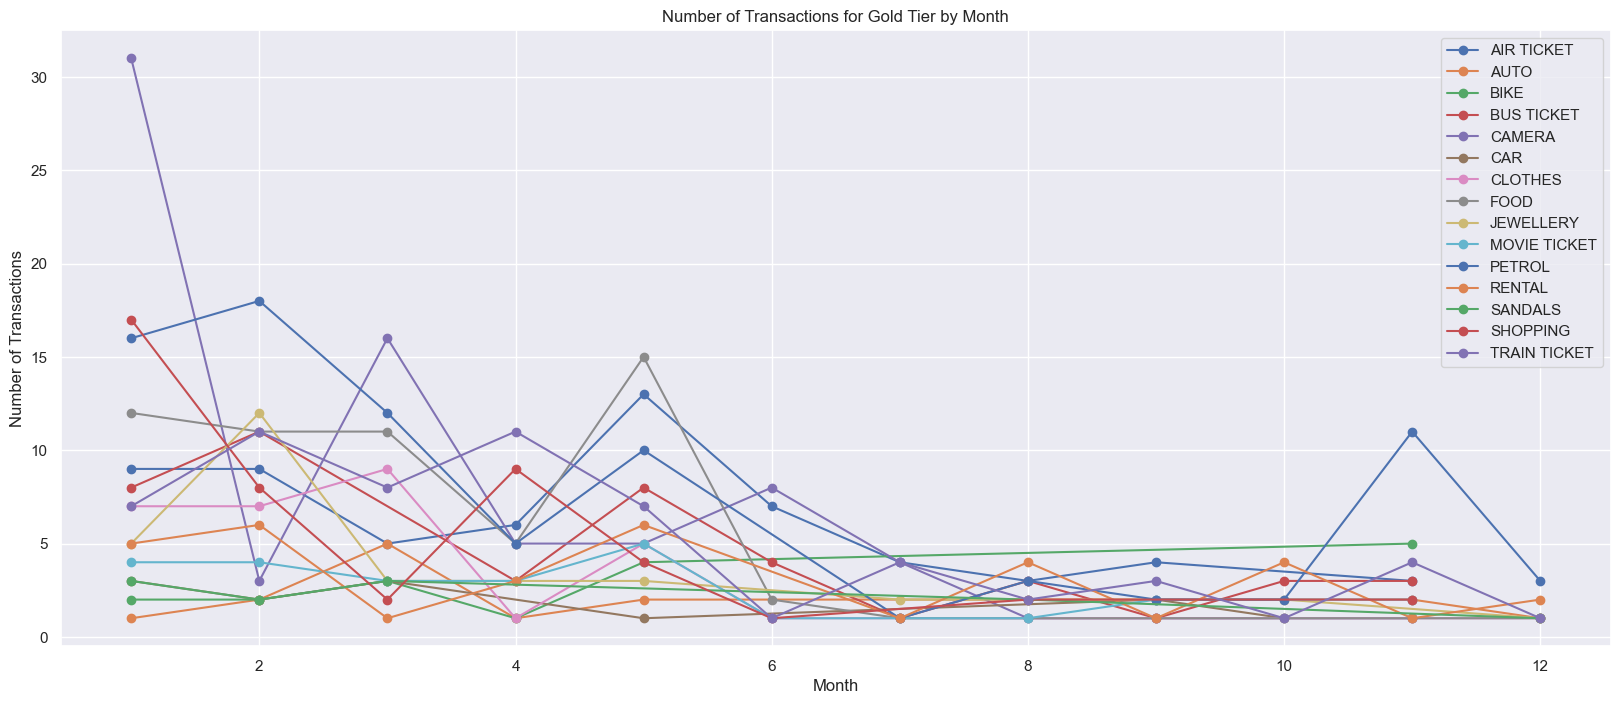

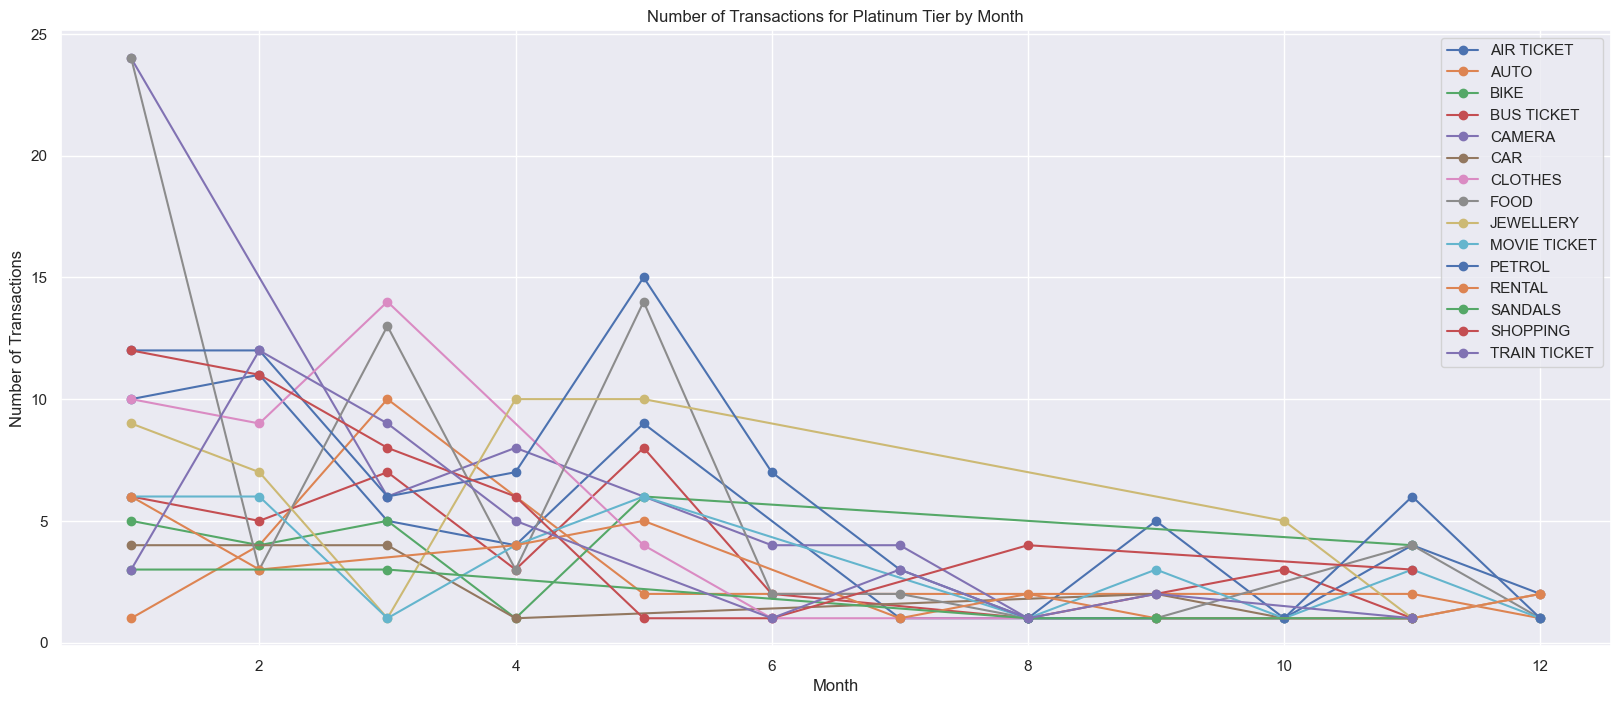

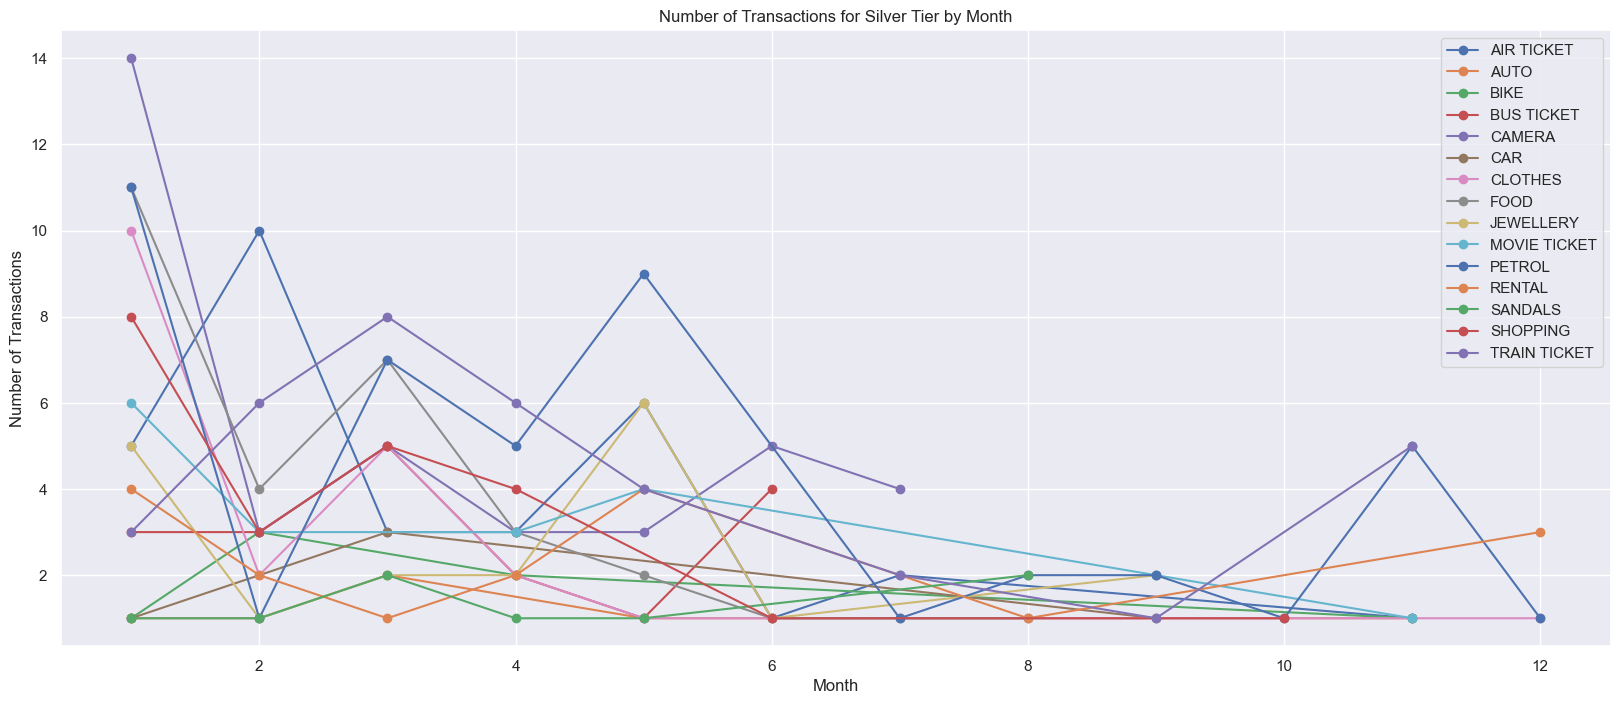

In [230]:
# First, convert 'Purchase_Date' to datetime and extract the month if you haven't already
Cus_N_Spend_df['Purchase_Date'] = pd.to_datetime(Cus_N_Spend_df['Purchase_Date'])
Cus_N_Spend_df['Purchase_Month'] = Cus_N_Spend_df['Purchase_Date'].dt.month

# Then, group the data by 'Purchase_Month', 'Tier', and 'Type' and count the transactions
agg_funcs = {
    'Spend_Amt': ['sum'],
    'Type':['count']
}

monthly_type_data = Cus_N_Spend_df.groupby(['Purchase_Month', 'Tier', 'Type']).agg(agg_funcs).reset_index()
monthly_type_data.columns = ['_'.join(col).strip() for col in monthly_type_data.columns]

# Create a list of all unique Tiers and Types
unique_tiers = monthly_type_data['Tier_'].unique()
unique_types = monthly_type_data['Type_'].unique()

# Create line plots for each Tier
for tier in unique_tiers:
    plt.figure(figsize=(20, 8))

    # Filter data for the specific tier
    tier_data = monthly_type_data[monthly_type_data['Tier_'] == tier]
    
    for unique_type in unique_types:
        type_data = tier_data[tier_data['Type_'] == unique_type]
        plt.plot(type_data['Purchase_Month_'], type_data['Type_count'], label=f'{unique_type}', marker='o')

    plt.title(f'Number of Transactions for {tier} Tier by Month')
    plt.xlabel('Month')
    plt.ylabel('Number of Transactions')
    plt.legend()
    plt.show()

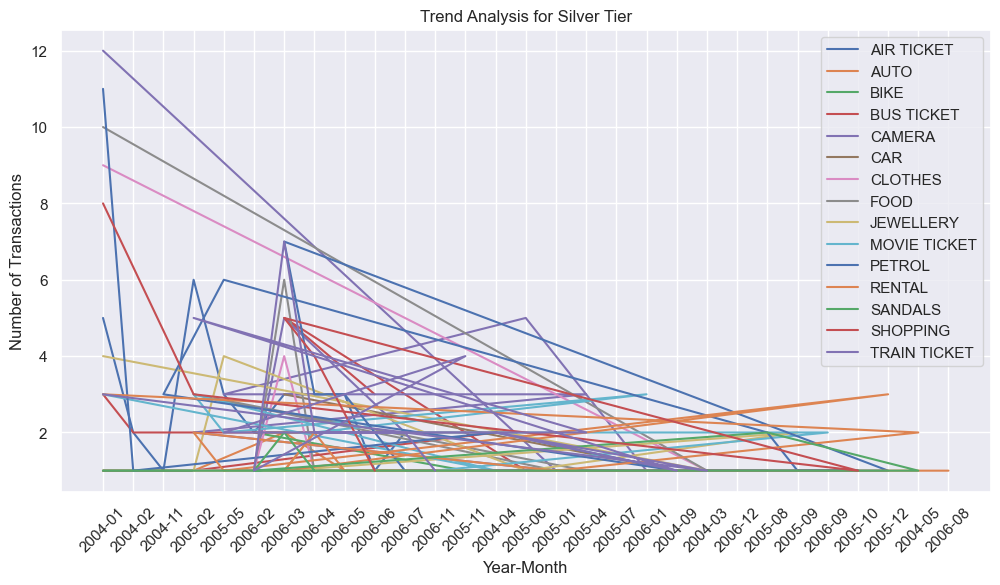

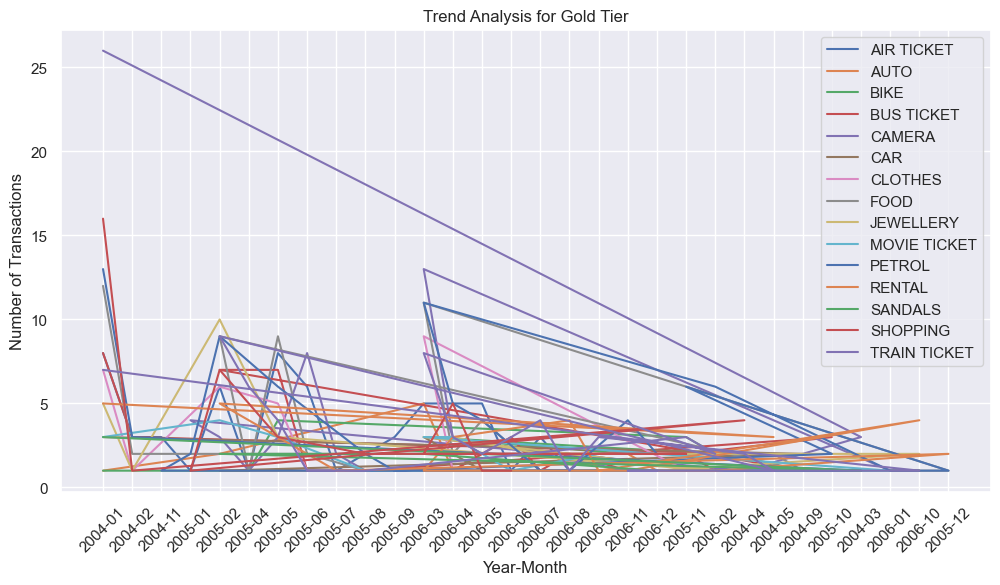

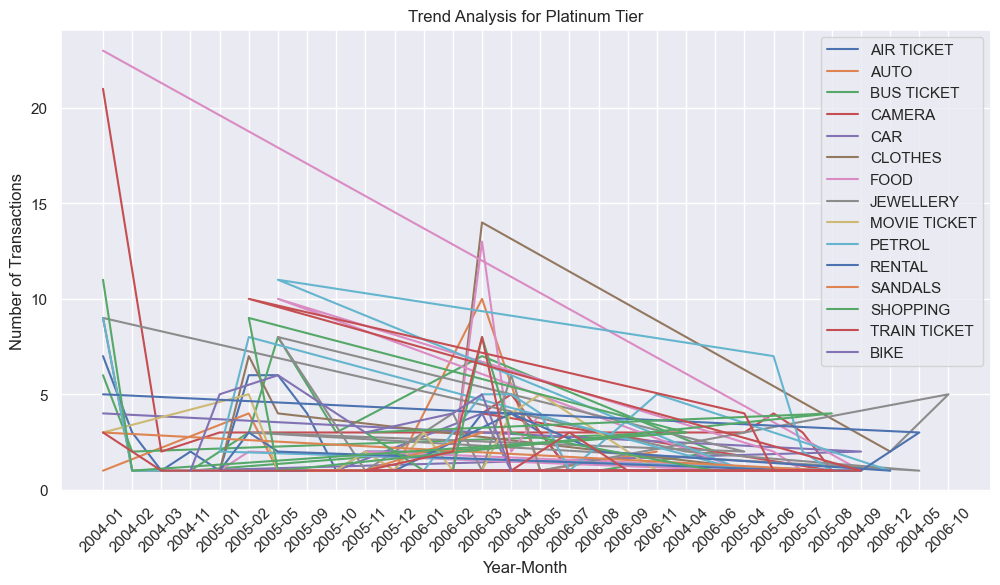

In [231]:
# Assume Cus_N_Spend_df is your DataFrame

# Convert 'Purchase_Date' to datetime if it's not already
Cus_N_Spend_df['Purchase_Date'] = pd.to_datetime(Cus_N_Spend_df['Purchase_Date'])

# Create a new column containing only year and month
Cus_N_Spend_df['YearMonth'] = Cus_N_Spend_df['Purchase_Date'].dt.to_period('M')

# Group by YearMonth, Tier, and Type and sum the transactions
agg_funcs = {
    'Spend_Amt': ['sum'],
    'Type': ['count']
}

monthly_data = Cus_N_Spend_df.groupby(['YearMonth', 'Tier', 'Type']).agg(agg_funcs).reset_index()
monthly_data.columns = ['_'.join(col).strip() for col in monthly_data.columns]

# Convert Period back to string for easier plotting
monthly_data['YearMonth_'] = monthly_data['YearMonth_'].astype(str)

# Plotting the graph
for tier in ['Silver', 'Gold', 'Platinum']:
    tier_data = monthly_data[monthly_data['Tier_'] == tier]
    
    plt.figure(figsize=(12, 6))
    
    for type_of_transaction in tier_data['Type_'].unique():
        specific_data = tier_data[tier_data['Type_'] == type_of_transaction]
        plt.plot(specific_data['YearMonth_'], specific_data['Type_count'], label=type_of_transaction)

    plt.title(f'Trend Analysis for {tier} Tier')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.legend()
    plt.show()


In [232]:
#How much is their credit card limited? Avg Med?

# Define is_skewed function
def is_skewed(mean, median):
    if mean > median:
        return 'Right'
    elif mean < median:
        return 'Left'
    else:
        return 'Symmetric'

# Group by 'Tier' and then aggregate
summary_stats = Cus_cy_df.groupby('Tier')['Limit'].agg(['count','median','mean','std', 'sum']).round(2).reset_index() 
summary_stats['skew'] = summary_stats.apply(lambda row: is_skewed(row['mean'], row['median']), axis=1)
#summary_stats['var'] = summary_stats['var'].apply(lambda x:'{:,.0f}'.format(x))

summary_stats

#how does bank deal with values that have more then 2 decimal place?

NameError: name 'Cus_cy_df' is not defined

In [ ]:
mode_values = Cus_cy_df.groupby('Tier')['Limit'].describe().round(2).reset_index()
mode_values

In [ ]:
#Clean_Repay_df
#Cus_df.nunique()
#Cus_df.info()
#Spend_df

# SandBox Area

In [ ]:
# Price_list = {'Cheeseburger': 8, 'Fries': 5, 'Lasagna': 12, 'Soup': 5, 'Spaghetti': 10}

# print(Price_list['Spaghetti'])
# Price_list.get('Spaghetti')


# #reassign all the key to different meaning.


In [ ]:
# nums = [1,35,12,24,31,51,70,100]


# def count (number):
#     number = sorted(number)
#     x = 0
#     while number[x]<20:
#         x+=1
#     return x
    
# count (nums)


